<a href="https://colab.research.google.com/github/rjanow/Masterarbeit/blob/main/1_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting UVI with LSTMs

[Notebook 0: Data Cleaning](./0_DataCleaning.ipynb)

[Notebook 1: EDA](./1_EDA.ipynb)

[Notebook 2: Modeling and Predictions](./2_Modeling_and_Predictions.ipynb)

[Notebook 3: Technical Report](./3_Technical_Report.ipynb)

Was wird in diesem Notebook gemacht?

## Verbinden mit der Google Drive und Import der benötigten Module:

In [42]:
# Verbinden mit der Google-Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
## import modules

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from datetime import datetime
from datetime import timedelta

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import matplotlib
import seaborn as sns

In [44]:
latitude = 50.2
longitude = 7.8

seconds_in_day = 24*60*60
seconds_in_year = (365.2425)*seconds_in_day

In [45]:
# Pfad zur CSV-Datei auf Google Drive
name_Messwerte = 'Messdaten.csv'
name_Vorhersage = 'Vorhersage.csv'
drive_path = '/content/drive/My Drive/Colab_Notebooks/Clean_Data/'
output_plot_path = '/content/drive/My Drive/Colab_Notebooks/plot_daily_UVI/'

In [46]:
# Import der Daten für die EDA
df_UVI = pd.read_csv(drive_path + name_Messwerte)
df_CAMS = pd.read_csv(drive_path + name_Vorhersage)

# Messzeitpunkt in Datetime umwandeln
df_UVI.set_index('Datetime', inplace=True)
df_CAMS.set_index('Datetime', inplace=True)

df_UVI.index = pd.to_datetime(df_UVI.index)
df_CAMS.index = pd.to_datetime(df_CAMS.index)

In [47]:
# Stündlicher Durchschitt ohne Nullen
df_UVI_hourly = df_UVI[df_UVI['UVI'] != 0][['UVI','erythem', 'SZA']].resample('H').mean()

In [48]:
# Stündlicher Durchschitt mit Nullen
df_UVI_hourly_withZero = df_UVI[['UVI','erythem', 'SZA']].resample('H').mean()

## Allgemeine Informationen:

In [49]:
print(df_UVI.info(), '\n --------------------- \n', df_UVI.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 101741 entries, 2022-06-15 07:21:00 to 2023-05-26 09:12:00
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     101741 non-null  int64  
 1   Datum          101741 non-null  object 
 2   Uhrzeit        101741 non-null  object 
 3   Messzeitpunkt  101741 non-null  float64
 4   erythem        88156 non-null   float64
 5   UVI            101694 non-null  float64
 6   DiffGreater2   101741 non-null  float64
 7   SZA            101741 non-null  float64
 8   time_sin       101741 non-null  float64
 9   time_cos       101741 non-null  float64
 10  date_sin       101741 non-null  float64
 11  date_cos       101741 non-null  float64
 12  Date           101741 non-null  object 
 13  Hour           101741 non-null  int64  
dtypes: float64(9), int64(2), object(3)
memory usage: 11.6+ MB
None 
 --------------------- 
 Unnamed: 0           0
Datum             

In [50]:
df_UVI_hourly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8283 entries, 2022-06-15 07:00:00 to 2023-05-26 09:00:00
Freq: H
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   UVI      3632 non-null   float64
 1   erythem  3163 non-null   float64
 2   SZA      3632 non-null   float64
dtypes: float64(3)
memory usage: 258.8 KB


In [51]:
df_UVI_hourly_withZero.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8283 entries, 2022-06-15 07:00:00 to 2023-05-26 09:00:00
Freq: H
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   UVI      3651 non-null   float64
 1   erythem  3186 non-null   float64
 2   SZA      3651 non-null   float64
dtypes: float64(3)
memory usage: 258.8 KB


## Plotten der Dataframes:

### Plot der Tagesdurchschnitte:

In [53]:
def plot_daily_mean_data(df1, df2, value_column1='UVI', value_column2='Wert2'):

    # Resample auf tägliche Auflösung und Berechnung des Durchschnitts
    df1_daily = df1.resample('D').mean()
    df2_daily = df2.resample('D').mean()

    # Erstellen Sie den Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df1_daily.index, df1_daily[value_column1], label='DataFrame 1', marker='o')
    plt.plot(df2_daily.index, df2_daily[value_column2], label='DataFrame 2', marker='x')

    plt.title('Tägliche Messwerte')
    plt.xlabel('Datum')
    plt.ylabel('Durchschnittlicher Messwert')
    plt.legend()
    plt.grid(True)

    # Rotieren Sie die X-Achsenbeschriftungen für bessere Lesbarkeit
    plt.xticks(rotation=45)

    # Zeigen Sie den Plot an
    plt.tight_layout()
    plt.show()

In [54]:
# plot_daily_mean_data(df_UVI, df_CAMS)

### Plot der täglichen Verläufe:

In [55]:
df_plot_daily = pd.concat([df_UVI[['UVI', 'SZA']], df_CAMS[['aod469', 'uvbed', 'uvbedcs', 'tcc']]], axis = 1)

In [56]:
def create_daily_plots(df, columns_to_plot):
    # Gruppieren nach Tag
    grouped = df.groupby(df.index.date)

    # Stil für Seaborn-Plots festlegen
    sns.set(style="darkgrid")

    for date, group in grouped:
        fig, ax1 = plt.subplots(figsize=(10, 6))  # Hauptfigur und erste Achse erstellen

        twin1 = ax1.twinx()
        twin2 = ax1.twinx()
        twin3 = ax1.twinx()
        twin4 = ax1.twinx()

        twin1.spines.right.set_position(("axes", 1))
        twin2.spines.right.set_position(("axes", 1.1))
        twin3.spines.right.set_position(("axes", 1.22))
        twin4.spines.right.set_position(("axes", 1.33))

        # Erste Achse erstellen (links)
        sns.set(style="whitegrid")

        # # Zweiter Plot mit Seaborn auf der zweiten Y-Achse
        sns.lineplot(data=df, x=df.index, y='UVI', label='UVI', marker='o', color='b', ax=ax1)

        sns.lineplot(data=df, x=df.index, y='SZA', label='SZA', marker='o', color='r', ax=twin1)

        sns.lineplot(data=df, x=df.index, y='uvbed', label='UVI', marker='o', color='g', ax=twin2)

        sns.lineplot(data=df, x=df.index, y='uvbedcs', label='UVI CS', marker='o', color='k', ax=twin3)

        sns.lineplot(data=df, x=df.index, y='tcc', label='TCC', marker='o', color='y', ax=twin4)

        plt.xlabel('Uhrzeit')
        plt.legend(loc='upper left')
        plt.title(f'Tagesverlauf für den {date}')
        plt.show()

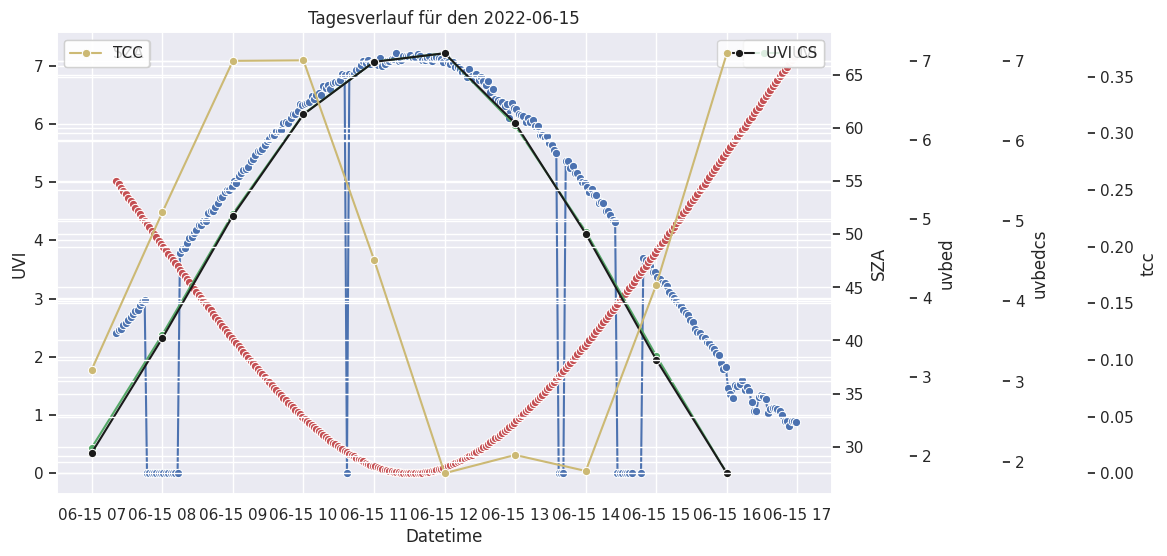

In [57]:

cols_to_plot = ['UVI', 'SZA', 'aod469', 'uvbed', 'uvbedcs', 'tcc']
create_daily_plots(df_plot_daily[0:300], cols_to_plot)

## Variablitätsindizes berechen:

## Korrelation der Stündlichen Mittelwerte:

Berechnen der Varabilitätsindices Indizes:

In [58]:
df_corr_hour = pd.concat([df_UVI_hourly[['UVI', 'SZA']], df_CAMS[['aod469', 'aod550', 'hcc', 'mcc', 'lcc', 'tcc', 'uvbed', 'uvbedcs']]], axis = 1)

In [59]:
df_corr_hour

,UVI,SZA,aod469,aod550,hcc,mcc,lcc,tcc,uvbed,uvbedcs
Datetime,,,,,,,,,,
2022-06-15 07:00:00,2.686945,53.151062,0.152110,0.121109,0.091481,0.0,0.000000,0.091481,2.109007,2.109151
2022-06-15 08:00:00,4.378194,43.431673,0.162309,0.129266,0.230113,0.0,0.000000,0.230113,3.538085,3.539376
2022-06-15 09:00:00,5.684107,36.261871,0.170056,0.135440,0.363832,0.0,0.000000,0.363832,5.067127,5.071212
2022-06-15 10:00:00,6.736104,30.156914,0.176425,0.140516,0.364290,0.0,0.000000,0.364290,6.330322,6.335601
2022-06-15 11:00:00,7.114456,27.689482,0.180305,0.143640,0.188470,0.0,0.000000,0.188470,6.991692,6.991999
...,...,...,...,...,...,...,...,...,...,...
2023-05-26 05:00:00,0.453827,73.676475,0.439879,0.354388,0.000000,0.0,0.004669,0.004669,0.286659,0.286764
2023-05-26 06:00:00,1.170444,64.313051,0.424471,0.342194,0.000000,0.0,0.001877,0.001877,0.814179,0.814284
2023-05-26 07:00:00,2.363173,54.880384,0.402243,0.324256,0.000000,0.0,0.008515,0.008515,1.755774,1.756089


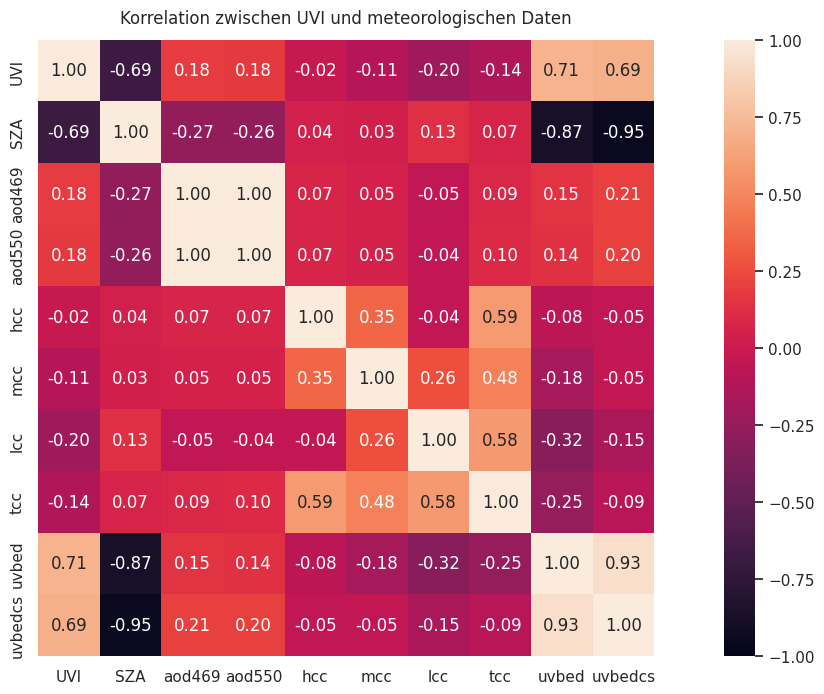

In [60]:
# Increase the size of the heatmap.
plt.figure(figsize=(18, 8))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df_corr_hour.corr(), fmt='.2f', vmin=-1, vmax=1, annot=True, square=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Korrelation zwischen UVI und meteorologischen Daten', fontdict={'fontsize':12}, pad=12);

## Kreuzkorrelation der Messwerte und der Vorhersagewerte:

https://towardsdatascience.com/how-to-do-an-eda-for-time-series-cbb92b3b1913

## Hauptkompinentenanlyse

- Anzahl der Merkmale reduzieren
- Visualisierung durch Dimensionsreduktion


In [61]:
df_corr_PCA = df_corr_hour.fillna(0)

In [62]:
# Daten standardisieren
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_corr_PCA)

In [63]:
# PCA durchführen
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

In [64]:
# Das Ergebnis anzeigen
print("PCA-Ergebnis:")
print(pca_result)

PCA-Ergebnis:
[[1.20296599 2.38538912]
 [2.43269162 4.06791073]
 [3.6120351  5.64127557]
 ...
 [2.1877666  2.15973459]
 [2.91494187 3.77445248]
 [4.1231726  4.41488485]]


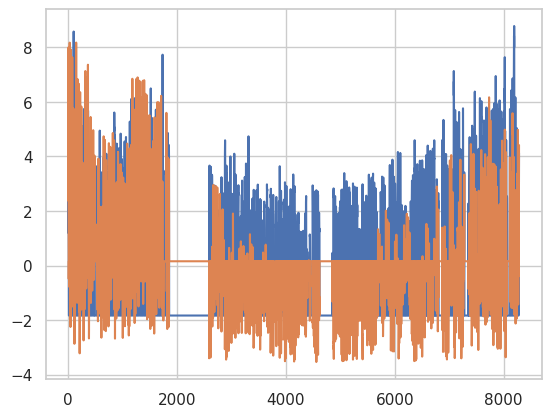

In [65]:
plt.plot(pca_result)